In [1]:
import torch
import torch.nn as nn

In [2]:
from importlib import reload

In [3]:
import libmotivation
reload(libmotivation)
from libmotivation import *


In [4]:
user_list = get_users_with_choose_difficulty()

In [5]:
user_to_difficulty_items = {}
for user in user_list:
  user_to_difficulty_items[user] = get_choose_difficulty_items_for_user(user)

In [6]:
for user in user_list:
  difficulty_items = user_to_difficulty_items[user]
  if len(difficulty_items) > 0:
    print(difficulty_items[0])
    break


{'_id': ObjectId('5c104667c6466e0014e3a47f'), 'url': 'https://www.facebook.com/', 'tab_id': 279, 'session_id': 0, 'is_new_session': True, 'is_preview_mode': False, 'is_suggestion_mode': False, 'is_previously_seen': False, 'type': 'impression', 'intervention': 'internal/choose_difficulty', 'userid': '8d2c9eb27dee2dc85bca705b', 'install_id': '70870c04da0d5fee89b69c40', 'day': 1075, 'synced': 0, 'timestamp': 1544570471554.0, 'localtime': 'Tue Dec 11 2018 23:57:49 GMT+0100 (Central European Standard Time)', 'itemid': 'a8b4d51da34a71ebb1b33824', 'log_major_ver': '8', 'log_minor_ver': '1', 'habitlab_version': '1.0.258', 'id': 1, 'logname': 'internal/choose_difficulty', 'timestamp_local': 1544569069091.0}


In [7]:
print(get_most_common_difficulty_for_user('8d2c9eb27dee2dc85bca705b'))

nothing


In [8]:
print(get_most_common_difficulty_overall())

nothing


In [9]:
def get_correctness_of_naive_overall_strategy(user):
  output = {'correct': 0, 'incorrect': 0}
  difficulty_counts = get_choose_difficulty_counts_for_user(user)
  most_common = get_most_common_difficulty_overall()
  if most_common == None:
    return None
  output['total'] = sum(difficulty_counts.values())
  if output['total'] == 0:
    return None
  output['correct'] = difficulty_counts.get(most_common, 0)
  output['incorrect'] = output['total'] - output['correct']
  output['accuracy'] = output['correct'] / output['total']
  return output

In [10]:
def get_correctness_of_naive_peruser_strategy(user):
  output = {'correct': 0, 'incorrect': 0}
  difficulty_counts = get_choose_difficulty_counts_for_user(user)
  most_common = get_most_common_difficulty_for_user(user)
  if most_common == None:
    return None
  output['correct'] = difficulty_counts[most_common]
  output['total'] = sum(difficulty_counts.values())
  output['incorrect'] = output['total'] - output['correct']
  output['accuracy'] = output['correct'] / output['total']
  return output

In [11]:
correctnes_of_naive_per_user = []
for user in user_list:
  correctness_info = get_correctness_of_naive_peruser_strategy(user)
  if correctness_info == None:
    continue
  accuracy = correctness_info['accuracy']
  correctnes_of_naive_per_user.append(accuracy)

print(np.median(correctnes_of_naive_per_user))
print(np.mean(correctnes_of_naive_per_user))

0.6666666666666666
0.7035437782954957


In [12]:
correctnes_of_naive_per_user = []
for user in user_list:
  correctness_info = get_correctness_of_naive_overall_strategy(user)
  if correctness_info == None:
    continue
  accuracy = correctness_info['accuracy']
  correctnes_of_naive_per_user.append(accuracy)

print(np.median(correctnes_of_naive_per_user))
print(np.mean(correctnes_of_naive_per_user))

0.3333333333333333
0.4041840943289177


In [95]:
num_correct_unnormalized = 0
num_total_unnormalized = 0
for user in user_list:
  correctness_info = get_correctness_of_naive_overall_strategy(user)
  if correctness_info == None:
    continue
  num_correct_unnormalized += correctness_info['correct']
  num_total_unnormalized += correctness_info['total']
  #accuracy = correctness_info['accuracy']
  #correctnes_of_naive_per_user.append(accuracy)

#print(np.median(correctnes_of_naive_per_user))
#print(np.mean(correctnes_of_naive_per_user_unnormalized))
print(num_correct_unnormalized / num_total_unnormalized)

0.485751398653191


In [94]:
num_correct_unnormalized = 0
num_total_unnormalized = 0
for user in user_list:
  correctness_info = get_correctness_of_naive_peruser_strategy(user)
  if correctness_info == None:
    continue
  num_correct_unnormalized += correctness_info['correct']
  num_total_unnormalized += correctness_info['total']
  #accuracy = correctness_info['accuracy']
  #correctnes_of_naive_per_user.append(accuracy)

#print(np.median(correctnes_of_naive_per_user))
#print(np.mean(correctnes_of_naive_per_user_unnormalized))
print(num_correct_unnormalized / num_total_unnormalized)

0.7220582705696023


In [15]:
n_features = 4 # the choice at each step. nothing, easy, medium, hard
n_categories = 4 # the number of categories we are categorizing among. nothing, easy, medium, hard


In [28]:
difficulty_to_idx = {
  'nothing': 0,
  'easy': 1,
  'medium': 2,
  'hard': 3,
}

# def difficulty_to_idx(difficulty):
#   return {
#     'nothing': 0,
#     'easy': 1,
#     'medium': 2,
#     'hard': 3,
#   }[difficulty]

In [33]:
def make_tensors_for_user(user):
  features = make_features_for_user(user)
  return make_tensors_from_features(features)

def make_tensor_from_prior_difficulties_list(prior_difficulties):
  tensor = torch.zeros(len(prior_difficulties), 1, n_features)
  for idx,difficulty in enumerate(prior_difficulties):
    difficulty_idx = difficulty_to_idx[difficulty]
    tensor[idx][0][difficulty_idx] = 1
  return tensor

def make_tensor_from_chosen_difficulty(chosen_difficulty):
  difficulty_idx = difficulty_to_idx[chosen_difficulty]
  tensor = torch.tensor([difficulty_idx], dtype=torch.long)
  return tensor

def make_tensors_from_features(features):
  output = []
  for feature in features:
    chosen_difficulty = feature['difficulty']
    prior_difficulties = feature['prior_difficulties']
    category_tensor = make_tensor_from_chosen_difficulty(chosen_difficulty)
    feature_tensor = make_tensor_from_prior_difficulties_list(prior_difficulties)
    output.append({'category': category_tensor, 'feature': feature_tensor})
  return output

def make_features_for_user(user):
  output = []
  difficulty_items = get_choose_difficulty_items_for_user(user)
  prior_difficulties = []
  for item in difficulty_items:
    if 'is_random' in item and item['is_random'] == True:
      continue
    if 'type' not in item:
      continue
    if item['type'] != 'action':
      continue
    if 'difficulty' not in item:
      continue
    difficulty = item['difficulty']
    output.append({'difficulty': difficulty, 'prior_difficulties': prior_difficulties[:]})
    prior_difficulties.append(difficulty)
    if len(prior_difficulties) > 10:
      prior_difficulties = prior_difficulties[-10:]
  return output


In [25]:
print(make_tensors_from_features([{'difficulty': 'easy', 'prior_difficulties': []}]))
print(make_tensors_from_features([{'difficulty': 'easy', 'prior_difficulties': ['easy', 'nothing']}]))


[{'category': tensor([1]), 'feature': tensor([], size=(0, 1, 4))}]
[{'category': tensor([1]), 'feature': tensor([[[0., 1., 0., 0.]],

        [[1., 0., 0., 0.]]])}]


In [34]:
all_data = []
for user in user_list:
  print(user)
  tensors = make_tensors_for_user(user)
  for tensor in tensors:
    all_data.append(tensor)

e0ea34c81d4b50cddc7bd752
d45b8b82dec8ec3c591fdbd7
f4d95006c663a799d9185576
8d2c9eb27dee2dc85bca705b
4a5f492c987b873871be4c12
78cc8c70b8be7412e00a1575
04c7fb2ae3098eab5ae390b8
8642884bd204eafc660a04a2
9ca53f1f33ac3e25c2e3f3d2
6e055258e3625ab1db57f0fa
9c00827409f8c296d67f78b4
687606ae6354d8b707f064ee
57ddb2820db2de361757d21b
af8454409cde73bead9d1071
eccfe39b9019a3f566346399
f32cf25130f6fa751892960e
8f77439cf19de38abfd4a417
3bc557eda64de5ff9d2e6fca
16043b6d098957d10448c009
edc3437cabf565d7a8c2f96c
88550c3144f8e1a6e84e83e2
3bc201cd34fc67185861245e
472a909dcf35ed6f1bc6da82
f45c319882842376492cffa7
150f93e5b7dea556c943813e
93b71831840fb44e554b6e36
cb266f371364b060f117b6a1
4e69f3aebac131196a8f2912
834ab49ae4351c22a1d49c2d
43a6fdadccd61a51caf5b588
968e70f748b83408bf3a9fa3
f6e9666fa6fd68a8ff0e2781
48df425ff6b2910b961070e5
ffdc2b2d686dbf9c8c621b35
42564d59c50078ce37d551e1
9595707af25dc9cf08d162f2
414492408538c282663be78d
8880741c0eb16b95ba062848
cc43e1c331c9d74bf7b00fc6
ae97c36156bb44a178a6519d


ce1ef1c40c2bd0dd1e2f3aa2
b120e76e564050b2d0457792
99dfe99b1f4d6fa8cdbb4110
c57b61dbfa89921bf4679013
2fb4052db10fb9e1d796c14f
44c361621083a0c056b029b4
d2a3afc469e10fac6f90a5e5
759798d48ea480cd146738d4
1310cd2f7f35173a9551c8cf
8e2da14192c115ee45870d0c
4bebe3f9d6a73dcfa0ba288e
f2ca89d4971eba6f0a2b4da7
b02ec08559176d815a86c29c
f0b3d19bb278c0334accee9f
f4777b7e5d213643f6f7be96
6584dc6e6039cf7bc6a65d78
fb9a51627e26f2af8dab5dc8
4c849873e044b007b91f7f39
90440b09cd2c17ca7784f21d
572a93aa3041afcab9c816e2
b570d0d6f46f095ccdd24376
40b957b71fcc72d41866e6b8
3056a2d989be02294adab708
0038a28ca863a4f560d099e0
63b6228a68cbc5f3597e9743
92202175520ab67835acedff
78cb68240cb3a717a5d6fa31
480015300ad3d0c4520023f2
48c5e9231f6e69e87f68009d
c4bddbc8daa7eaaf6711bf71
de0f8a6433da584c0fa066f3
77d96358edb2978a0899bfcc
7669818720e10485946be94c
7837eb10f86c3a8baf835fcc
c7e7e27d6fb15ced618a19d0
bc2a2a9aa64af2b5cd1b403a
27cfcc4681e11b23b54acf63
a8bf6d62f2be3db749ab5c85
235bb31da5dc39b661d12d22
9ee9b7534c9bcafec6a13773


5d553942942322c5fce88a96
1c499412ea5b034f2d45e0fe
a6a4b8327878e0849f128028
39142cdc607dc59a7bc1b095
f7bc103e54d34c39fe4f34bd
63246bd51af632966de41ff5
2b094a50ccfbe785e2ab83a9
c26b116cdec7c37ff5dfc612
cdc94c551609bd8a8c26b624
b83f7d5ff4c3695712f94f3b
75d2f3897e1f41b7f1a9f584
49d39fa16572b1652523d87e
85d88b9d04b7c08dd3ad0c11
8e9a3e1717d60f22873441b6
ac5db577f6903de2b1742f1a
5b30481359252552b9dde0fb
a0d5dad7a6149744236f0d12
f59bfe48cbe62d84b67a6342
2371a488fcceec7a4d4f39c8
2df5bba93a8061846ef8df22
42b989a6aa5f4ca2c34f57d9
428d7d492e9ac130032911ad
d8dc3a0d6a7ebf2ec16d067a
272bdfd42db21e042963fa11
59bab175c66b2e618f2640ec
491e5869a2a3df4408399f94
cd35f84b81596b0930f8d9b5
5e4a219b35c059a00c9131e2
714a57df8163e780463ca316
6f886b8df388d9d079cfa16b
84fee669212988443231d39c
9579d2bf5ad99f02dad5a9bf
79df2c00e38d43ff43d06221
cdd70c2b9066b2a94170c3d3
c6b4af032286d5e88a489cf2
f3c3cc381a98828dc9b61084
0db379d9ba899842a34a008c
54323b1146330f4acf7fc81b
5c69f950cbd4884f485874d0
f70fd960bb5c7d6d33606939


a15ec1df8563d89e22a86a06
c9bfddb9ff1866c43464db53
4de61ad85f25d309e80b16d3
164d75cd3331f4875695dc88
2ad489dd255f93d8bc0778bf
67394db81616b1bfb8b08ec9
7e9e145f21ae6bb5cbcd9edb
f8d9d591c85029914116c06c
a6a19651e3d2f91b60766a2d
8142ad13f231ee065fef7751
cd3081cf8876e6915585f64f
707250b303e876ee5cc6a61c
f6f5da37a72cc4f2f2e40e90
6b4506c2667bb9531faf2612
8e7d913d2db0628bfc8576b2
8b5ff72da60494eab03bfcea
e55333c1b7224fac4d96718b
a9b09d252c3424dbbae89aa6
8cec958ad0ebd685a9e10ad1
82943fd722bd132734ba7137
f42309bc714b8c7bdc9f6bd6
d1fb81fc24a959f94a8bf45b
cffb95c7f79f1a0793fe546f
5e0579cac972d7df2422a389
d55ad9882c951036e26b2562
f46cd7c2d0c00a73a132af12
7fb6a3a089b4a550d3940864
e5c3d57b9d1e78cc012a00ae
f105ece71904bbd5fe2f8ec3
ed0234ef70a2c1137a3d2620
986971231da7b0c335d218e2
0df2e3d9851b793b93f2a91a
e2e96854958c88b3dc27b828
118db85063bf29f7ab00f8a8
45c9c1e74ec0a48167838ca6
6b91725b5367b06acb6f916f
399f23dc477288c1ae772cbe
ca47a20eb3fcd212929e49bf
44046bbdac9b2e19024ab1d4
eb1d4655aa7d05f12cf95767


053c751b36829143d2e4cf6d
6f53cbef196d14989950c75e
e748eade7d7199d3458199f2
77178110beccb44ed888ecdd
7f52c8731b3ccc100adf56f2
aa99d940c34f7a7f63109910
f7e68a95224cf021acc029ef
88c51045776e621b6a08542e
7256721aeed534c20d50e7a9
0e543d5eb54137d5b3bed87a
e8a72c62421d1b1cacc2b6f1
0f2da3434e67cf15b0f2d1f8
e75beb5da9a5c7bc35a7d9d8
ff8ee5e4f9c07e70b0877544
af8df93a019bea99bdddd2af
0ddb5cfd930b7872282072b5
cfdddf1e79d4752496d0ce4f
8e135ee4e25cb0e1bda794db
97321319bdcc3341c04e5e3a
5b2bd9f5de389df5040f06c0
dc545c555ad5b031324d336a
0f803a4a2074894a544e3aa4
d9b3825ffb122366704d19ae
d5298604c749f1f448e82a75
cceb3953e4ff2a92f4465c0d
cdb894a79956e7016ed8eca4
28e451dd30f2023aa95eaf80
e7ebf944b2771f27cc5401e1
4619d4b5a4df03abf3d5bf96
bc47858afe4bb9b24f5ea5f6
4df8e676c58695ed9e4ce21e
5c34da9c723b7b7fb7830731
dfe9dbe3ba93f97dfa9d4ad1
6b746c00d81510987b1ec28a
ba0a177c1bfb21d24d95495d
e7a6aae17a6cbcbde1cd6969
4701b007958f2e62ec7af088
87c0da0f20094e00d30c17da
a1f49e2e0a2c4c9c9fde7ed9
e316f28e589b9d8d09b6e35e


In [48]:
def tensor_to_difficulty(tensor):
  difficulty_idx = tensor[0].data.cpu().numpy()
  return ['nothing', 'easy', 'medium', 'hard'][difficulty_idx]

print(make_tensor_from_chosen_difficulty('hard'))
print(tensor_to_difficulty((make_tensor_from_chosen_difficulty('hard'))))

tensor([3])
hard


In [67]:
training_data = all_data[:int(math.floor(len(all_data)*9/10))]
dev_and_test_data = all_data[len(training_data):]
dev_data = dev_and_test_data[:int(math.floor(len(dev_and_test_data)/2))]
test_data = dev_and_test_data[len(dev_data):]

def randomTrainingExample():
  data = random.choice(training_data)
  category = tensor_to_difficulty(data['category'])
  return category,data['category'],data['feature']


In [35]:
criterion = nn.NLLLoss()


In [36]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().cuda()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [37]:
torch.cuda.device_count()

1

In [38]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_features, n_hidden, n_categories).cuda()

In [64]:
def categoryFromOutput(output):
  top_n,top_i = output.topk(1)
  category_i = top_i[0].item()
  return ['nothing','easy','medium','hard'][category_i],category_i
print(output.topk(1))
print(categoryFromOutput(output))

(tensor([[-0.0171]], device='cuda:0', grad_fn=<TopkBackward>), tensor([[2]], device='cuda:0'))
('medium', 2)


In [99]:
import time
import math
import random

n_iters = 100000
print_every = 1000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category,category_tensor, line_tensor = randomTrainingExample()
    if line_tensor.size()[0] == 0:
      continue
    output, loss = train(category_tensor.cuda(), line_tensor.cuda())
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 3s) 0.1927 / easy ✓
2000 2% (0m 6s) 1.6820 / easy ✗ (nothing)
3000 3% (0m 9s) 0.3077 / nothing ✓
4000 4% (0m 12s) 0.0185 / easy ✓
5000 5% (0m 15s) 0.0345 / nothing ✓
6000 6% (0m 18s) 0.0169 / nothing ✓
7000 7% (0m 21s) 0.0310 / nothing ✓
8000 8% (0m 24s) 0.0241 / nothing ✓
9000 9% (0m 27s) 0.5251 / hard ✓
10000 10% (0m 30s) 0.0200 / nothing ✓
11000 11% (0m 33s) 0.0221 / nothing ✓
12000 12% (0m 35s) 0.0183 / nothing ✓
13000 13% (0m 38s) 0.0209 / nothing ✓
14000 14% (0m 41s) 0.0448 / hard ✓
15000 15% (0m 44s) 0.0290 / nothing ✓
16000 16% (0m 46s) 0.1923 / easy ✓
17000 17% (0m 49s) 0.0291 / nothing ✓
18000 18% (0m 52s) 0.0707 / nothing ✓
19000 19% (0m 55s) 0.0208 / nothing ✓
20000 20% (0m 57s) 0.2378 / nothing ✓
21000 21% (1m 0s) 0.0070 / nothing ✓
22000 22% (1m 3s) 0.0312 / medium ✓
23000 23% (1m 6s) 0.0141 / nothing ✓
24000 24% (1m 8s) 0.0245 / nothing ✓
25000 25% (1m 11s) 0.0195 / nothing ✓
26000 26% (1m 14s) 0.0485 / easy ✓
27000 27% (1m 17s) 0.0104 / easy ✓
28000 28% (1m 

In [69]:
%matplotlib inline


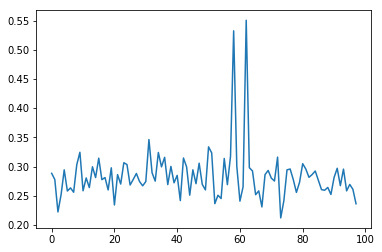

In [100]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
#plt.plot(all_losses[:100])
plt.plot(all_losses)

In [80]:
all_categories = ['nothing', 'easy', 'medium', 'hard']

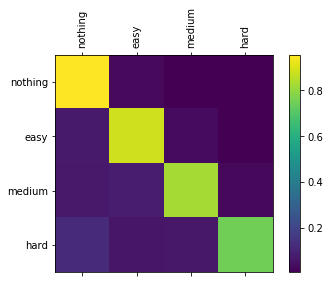

In [101]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().cuda()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, category_tensor, line_tensor = randomTrainingExample()
    if line_tensor.size()[0] == 0:
      continue
    output = evaluate(line_tensor.cuda())
    guess, guess_i = categoryFromOutput(output)
    category_i = difficulty_to_idx[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [102]:
#confusion = torch.zeros(n_categories, n_categories)
num_correct = 0
num_incorrect = 0
confusion = torch.zeros(n_categories, n_categories)

for item in dev_data:
  category_tensor = item['category']
  feature_tensor = item['feature']
  if feature_tensor.size()[0] == 0:
      continue
  difficulty = tensor_to_difficulty(category_tensor)
  difficulty_idx = difficulty_to_idx[difficulty]
  predicted_tensor = evaluate(feature_tensor.cuda())
  predicted_difficulty,predicted_difficulty_idx = categoryFromOutput(predicted_tensor)
  if predicted_difficulty_idx == difficulty_idx:
    num_correct += 1
  else:
    num_incorrect += 1
  confusion[difficulty_idx][predicted_difficulty_idx] += 1
  #print(predicted_difficulty)
  #print(difficulty)
  #break

print('num correct: ' + str(num_correct))
print('num incorrect: ' + str(num_incorrect))
print('percentage correct: ' + str(num_correct / (num_correct + num_incorrect)))

num correct: 2528
num incorrect: 562
percentage correct: 0.8181229773462784


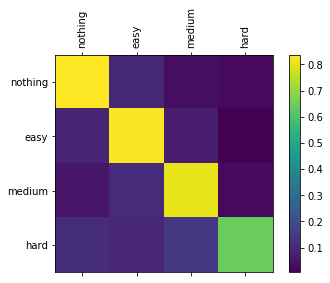

In [103]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()